In [ ]:
from pathlib import Path
import os
from model import *
import torch
from torch.utils.tensorboard import SummaryWriter

training_path = Path(r'X:\Training Data\Model 1 Training\train\spectrograms')

list_of_files = [training_path / x for x in os.listdir(training_path)]
list_of_files = list_of_files[:10]

train_data = Dataset(list_of_files)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

model = VAE(dropout=0.1).to(device)

learning_rate = 5e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

criterion = nn.MSELoss()

num_epochs = 5

writer = SummaryWriter('runs/loss_lr_2e5')
step = 0

for epoch in range(num_epochs):
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        x = batch.to(device)
        candidate, _ = model(x)

        optimizer.zero_grad()
        loss = criterion(candidate, x)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()
        writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1

    print('\nEpoch {}/{}'.format(epoch, num_epochs))
    print('Training Loss: {}'.format(loss.item()))


In [4]:
from tqdm import tqdm
latent = torch.zeros(size=(4000, 30))

model.eval()
for batch_idx, batch in tqdm(enumerate(train_loader)):
    x = batch.to(device)
    _, z = model(x)
    latent[batch_idx*64:(batch_idx+1)*64,:] = z


62it [00:00, 231.34it/s]


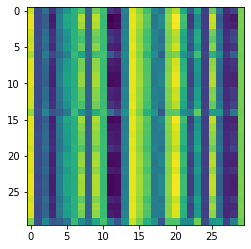

In [10]:
import matplotlib.pyplot as plt

plt.imshow(latent[3600:3630,:])

In [21]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

spec_slices = np.zeros(shape=(512, 4000))
for idx, file in enumerate(list_of_files):
    slice = np.load(file)
    spec_slices[:,idx*400:(idx+1)*400] = slice

latent = spec_slices.T

ssd = np.array([])
kneedle = None
for i in tqdm(range(1,50)):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(latent)
    ssd = np.append(ssd, kmeans.inertia_)
    if ssd.size >= latent.shape[0]-1:
        kneedle = KneeLocator(list(range(ssd.shape[0])), ssd, curve='convex', direction='decreasing');
if kneedle:
    if kneedle.knee:
        kmeans = KMeans(n_clusters=kneedle.knee, random_state=0)
else:
    kmeans = KMeans(n_clusters=1, random_state=0)
kmeans.fit(latent)
y_kmeans = kmeans.predict(latent)

100%|██████████| 49/49 [01:13<00:00,  1.49s/it]


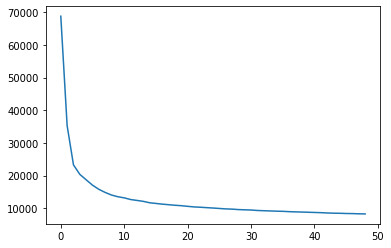

In [22]:
plt.plot(ssd)

In [23]:
print(np.where(y_kmeans > 0))

(array([], dtype=int64),)
